<a href="https://colab.research.google.com/github/Mollylst/DeepFake-Project/blob/main/PCA_on_DCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train-fake-stylegan1.zip' -d /content/dataset
!unzip -uq '/content/drive/MyDrive/FFHQ data 8:1:1/train_real.zip' -d /content/dataset

In [ ]:
!rm -rf my_che dataset

In [2]:
import numpy as np
from PIL import Image
from scipy import fftpack

def dct2(array):
    array = fftpack.dct(array, type=2, norm="ortho", axis=0)
    array = fftpack.dct(array, type=2, norm="ortho", axis=1)
    return array

def log_scale(array, epsilon=1e-12):
    """Log scale the input array.
    """
    array = np.abs(array)
    array += epsilon  # no zero in log
    array = np.log(array)
    return array

In [3]:
import cv2
import os
import numpy as np
import random
import torch
import torchvision
import os
from torchvision import datasets 
from torch.utils.data import random_split
import torchvision.transforms as transforms

def image2npy(label2idx, dir_path='/content/dataset'):
    i = 0
    data = []
    for (root, dirs, files) in os.walk(dir_path):
        for file in files: 
            img_path = os.path.join(root, file) 
            File = root.split('/')[-1] #name of the file which is label
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = np.asarray(image)
            image = dct2(image)
            image = log_scale(image)

            label = label2idx[File]
            data.append([np.asarray(image), label])
    return data

In [4]:
label2idx = {'fake':1, 'real': 0}
data = image2npy(label2idx, dir_path='/content/dataset')

X = np.array([i[0] for i in data]) # train feature
X_max = X.max(0)
X = X/X_max
y = np.array([i[1] for i in data]) # train label
np.save('drive/MyDrive/PCA-X-dct.npy', X)
np.save('drive/MyDrive/PCA-y-dct.npy', y)

print(len(X), len(y))

18000 18000


In [5]:
import numpy as np
image_data = []
X = np.load('drive/MyDrive/PCA-X-dct.npy')
y = np.load('drive/MyDrive/PCA-y-dct.npy')
for image in X:
    data = image.flatten()
    image_data.append(data)
print(image_data[0].shape)

(16384,)


In [6]:
from sklearn.model_selection import train_test_split
X = np.array(image_data)
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

In [8]:
from sklearn.decomposition import PCA
pca=PCA(n_components=650)
pca.fit(x_train)
PCA(copy=True, iterated_power='auto', n_components=650, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca.shape)
print(x_test_pca.shape)

(14400, 650)
(3600, 650)


(650, 16384)


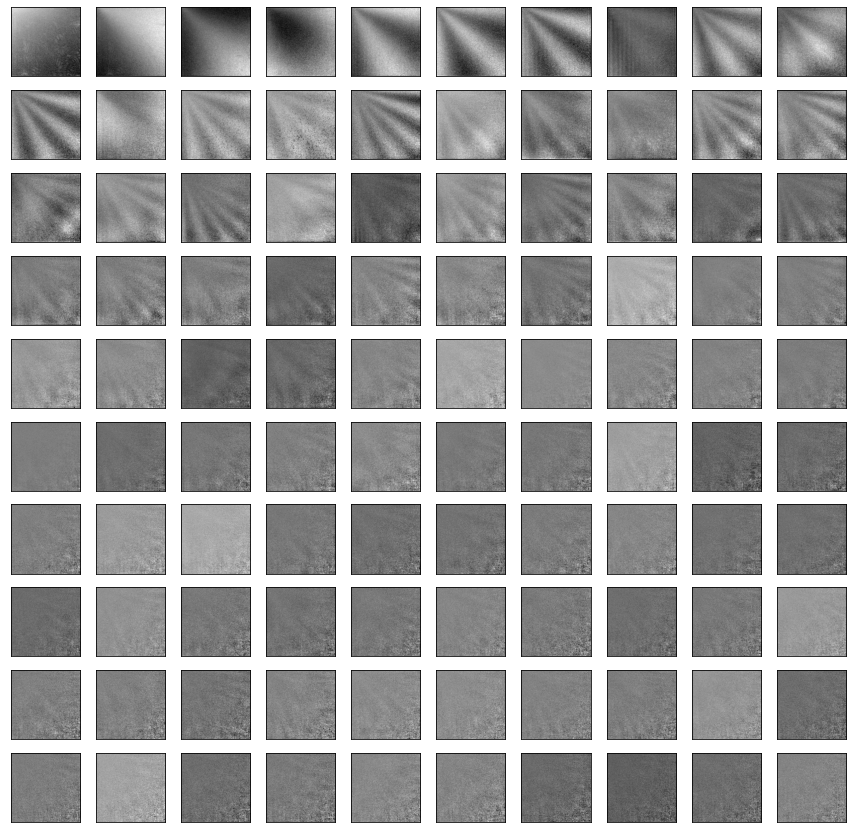

In [9]:
import matplotlib.pyplot as plt
V = pca.components_
V.shape
print(pca.components_.shape)
fig, axes = plt.subplots(10,10,figsize=(15,15),subplot_kw = {"xticks":[],"yticks":[]}) #不要显示坐标轴
#填充图像
for i, ax in enumerate(axes.flat):
    ax.imshow(V[i,:].reshape(128,128),cmap="gray") #选择色彩的模式

In [10]:
pca.explained_variance_ratio_

array([0.04905133, 0.0060846 , 0.00394885, 0.00177796, 0.00154596,
       0.00106132, 0.00074879, 0.00073251, 0.00063699, 0.00057181,
       0.00048933, 0.00048213, 0.00046273, 0.00044405, 0.000398  ,
       0.00038827, 0.00037197, 0.0003666 , 0.00036132, 0.00033763,
       0.00033291, 0.00032982, 0.00032301, 0.00031596, 0.0003154 ,
       0.00031029, 0.00030725, 0.0003043 , 0.00029988, 0.0002968 ,
       0.00029484, 0.00029431, 0.00029294, 0.00029046, 0.00028823,
       0.00028686, 0.00028627, 0.00028541, 0.00028472, 0.00028344,
       0.0002813 , 0.00028084, 0.00028029, 0.00028005, 0.00027873,
       0.00027809, 0.00027769, 0.00027713, 0.00027662, 0.00027626,
       0.0002761 , 0.0002749 , 0.00027466, 0.0002745 , 0.00027385,
       0.00027354, 0.00027317, 0.00027295, 0.00027228, 0.00027195,
       0.0002714 , 0.00027103, 0.00027092, 0.00027074, 0.00027037,
       0.00026988, 0.00026974, 0.00026961, 0.0002691 , 0.00026898,
       0.00026866, 0.00026844, 0.00026827, 0.00026797, 0.00026

In [11]:
pca.explained_variance_ratio_.sum()

0.2162232822501107

In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
logreg.fit(x_train_pca, y_train)
LR = logreg.score(x_test_pca, y_test)
print("LR: "+str(LR))

LR: 0.8061111111111111
